In [1]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

### **Prepare dataset**

In [3]:
batch_size = 512

train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 54000
Validation size: 6000
Test size: 10000


## **Build MLP network with `Better Optimizer `**




In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)

        return out

In [5]:
input_dims = 784
hidden_dims = 128
output_dims = 10

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

### **Training**

In [6]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.2326, Train_Acc: 0.1290, Validation Loss: 1.0544, Val_Acc: 0.2025
EPOCH 2/100, Train_Loss: 1.7115, Train_Acc: 0.1982, Validation Loss: 1.0145, Val_Acc: 0.2028
EPOCH 3/100, Train_Loss: 1.6837, Train_Acc: 0.2028, Validation Loss: 1.0169, Val_Acc: 0.1913
EPOCH 4/100, Train_Loss: 1.6842, Train_Acc: 0.1974, Validation Loss: 1.0170, Val_Acc: 0.1942
EPOCH 5/100, Train_Loss: 1.6799, Train_Acc: 0.2011, Validation Loss: 1.0112, Val_Acc: 0.1925
EPOCH 6/100, Train_Loss: 1.6572, Train_Acc: 0.2195, Validation Loss: 0.9297, Val_Acc: 0.3012
EPOCH 7/100, Train_Loss: 1.4742, Train_Acc: 0.3076, Validation Loss: 0.8664, Val_Acc: 0.3525
EPOCH 8/100, Train_Loss: 1.1864, Train_Acc: 0.4921, Validation Loss: 0.6072, Val_Acc: 0.5945
EPOCH 9/100, Train_Loss: 0.9144, Train_Acc: 0.6228, Validation Loss: 0.5109, Val_Acc: 0.7175
EPOCH 10/100, Train_Loss: 0.7712, Train_Acc: 0.7364, Validation Loss: 0.4390, Val_Acc: 0.7598
EPOCH 11/100, Train_Loss: 0.6754, Train_Acc: 0.7704, Validation Loss:

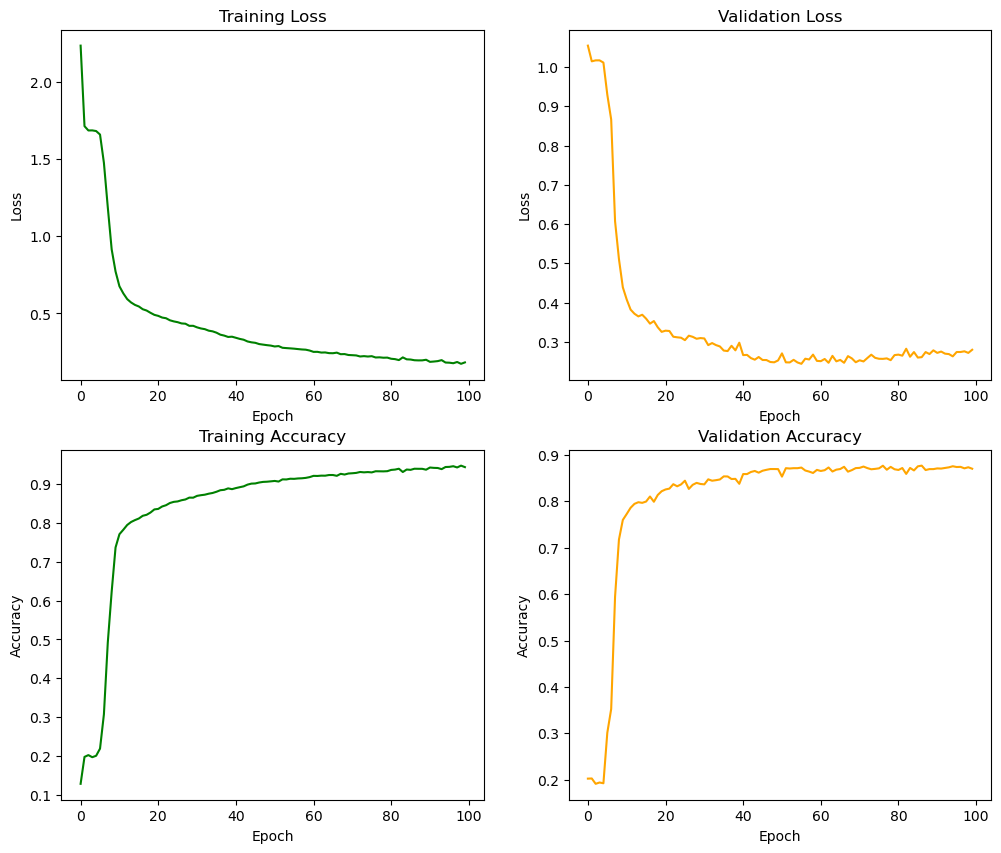

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### **Evaluation**

In [11]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.8701666666666666


In [12]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.8591
